In [1]:
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org sympy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy

np.random.seed(12)

# Starting with a dinamic system

Imagine model a tank system with one input from above and one output from the bottom.

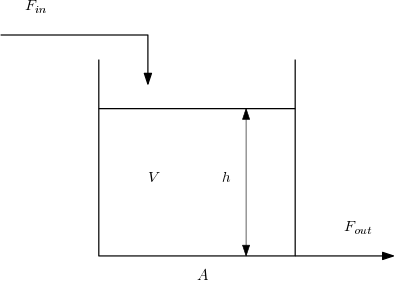

The following equations are valid for this case:

(1)   $ F_{out} = kh $

(2)   $ \frac{dh(t)}{dt} = \frac{1}{A} (F_{in} - F_{out})$

Where $ F_{in} $ inlet flow , $ F_{out} $ outlet flox $ h $ tank level and $ A $ as tank area

In [2]:
sympy.init_printing()

#variables
Fout, t = sympy.symbols('Fout, t', real=True)
h = sympy.Function('h')(t)
dhdt = h.diff(t)

#parameters
A = 1 # tank area in m2
k = 1 # constant
Fin = 2 # flow in m3
h0 = 1 #initial level

Replacing (1) in (2) then: 

(3)   $ \frac{dh(t)}{dt} = 2 - h(t)$

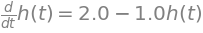

In [3]:
expr_final = sympy.Eq(dhdt, 1/A*(Fin-k*h))
expr_final

In [4]:
sol = sympy.dsolve(expr_final)
sol

In [5]:
C1 = sympy.Symbol('C1')
C1_ic = sympy.solve(sol.rhs.subs({t:0})-h0,C1)[0]
print(f'Initial Condition {C1_ic}')
equation = sol.subs({C1:C1_ic})

Initial Condition -1.00000000000000


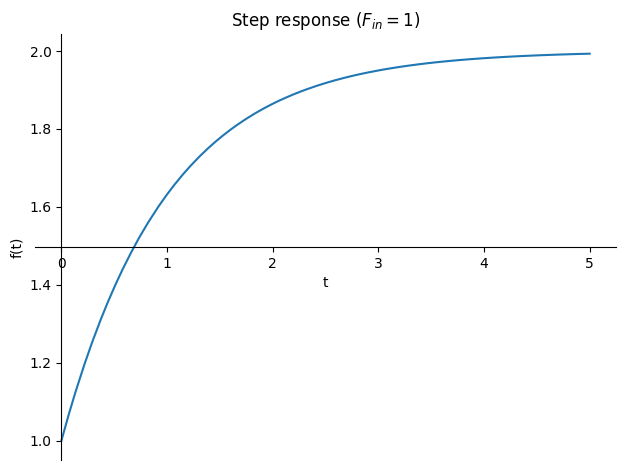

In [6]:
sympy.plotting.plot(equation.rhs, (t,0,5), title='Step response $ (F_{in}=1) $')
plt.show()

## Tank system simulation

Simulation will implement the equations and see the changes in level by changin the inlet flow $ F_{in} $. It will be a numeric simulation not literal as the previous session.

In [7]:
#simulation space
n = 60
tspan = (0, n)
t = np.linspace(*tspan, n) #redefining t

#defining data for input
Fin = pd.DataFrame()
Fin['time'] = np.arange(0,n,1)
Fin['Fin'] = np.random.randint(3 , size=n)

In [8]:
def get_fin(t):
    '''Interpolation to simulate'''
    return np.interp(t, Fin.time, Fin.Fin)

def dhdt(t, h):
    '''Tank level equations'''
    Fout = k*h
    return 1/A*(get_fin(t) - Fout)

import scipy.integrate
sol = scipy.integrate.solve_ivp(dhdt, tspan, [h0], t_eval=t)

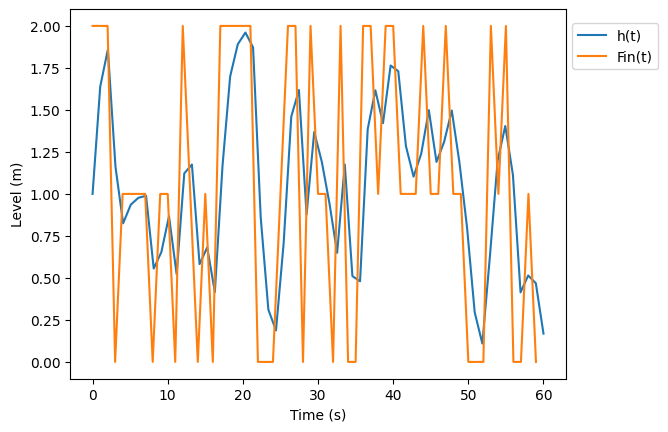

In [9]:
plt.plot(sol.t, sol.y.T, label='h(t)')
plt.plot(Fin.time, Fin.Fin, label='Fin(t)')
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.9))
plt.xlabel('Time (s)')
plt.ylabel('Level (m)')
plt.show()

## Classical approachs using ML

Is it possible to use classical ML algorithms ? 

In [10]:
# Features for dataset level at t-1 and Fin at t
feat = ['ht_1','Fin']
dataset = pd.DataFrame()
dataset['y'] = sol.y.reshape(-1)
dataset['ht_1'] = dataset['y'].shift(1)

dataset['Fin'] = Fin['Fin']

dataset.fillna(1, inplace=True)

In [11]:
dataset.head(5)

,y,ht_1,Fin
0,1.000000,1.000000,2
1,1.638010,1.000000,2
2,1.859907,1.638010,2
3,1.160358,1.859907,0
4,0.825198,1.160358,1


In [12]:
#train test split
test = dataset[40:]
train = dataset[:40] 

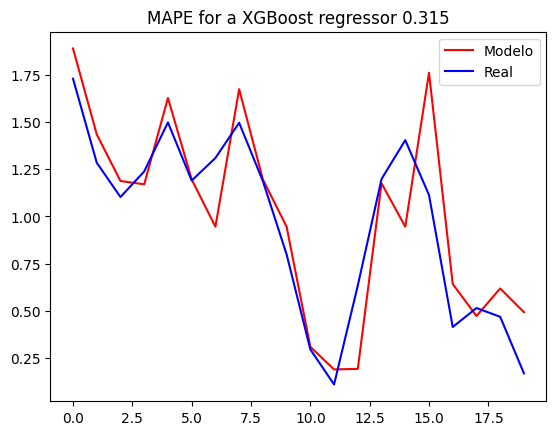

In [13]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

model = XGBRegressor()
model.fit(train[feat],train.y)

y_test = model.predict(test[feat])
plt.title(f'MAPE for a XGBoost regressor {mean_absolute_percentage_error(test.y.values, y_test):.3f}')
plt.plot(y_test, color='r', label='Modelo')
plt.plot(test.y.values, color='b', label = 'Real')
plt.legend()
plt.show()

In [14]:
# ARX model: h(t) = k1 * h(t-1) + k2 * Fin(t)
import statsmodels.formula.api as smf
model = smf.ols("y ~ ht_1 + Fin -1", data=train).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              1497.
Date:                Thu, 10 Nov 2022   Prob (F-statistic):                    7.27e-37
Time:                        10:15:26   Log-Likelihood:                          24.263
No. Observations:                  40   AIC:                                     -44.53
Df Residuals:                      38   BIC:                                     -41.15
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

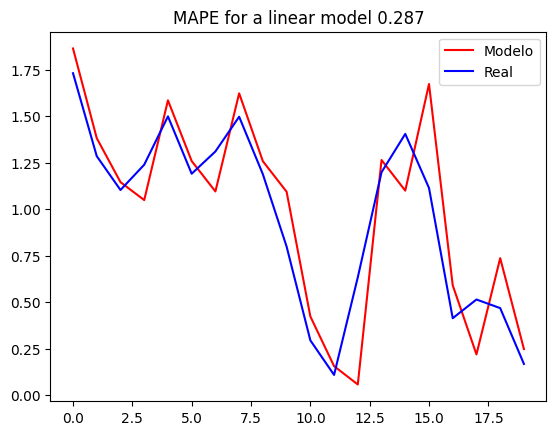

In [15]:
y_test = model.predict(test[feat])
plt.title(f'MAPE for a linear model {mean_absolute_percentage_error(test.y.values, y_test):.3f}')
plt.plot(y_test.values, color='r', label='Modelo')
plt.plot(test.y.values, color='b', label = 'Real')
plt.legend()
plt.show()

## Fitting a differencial equation with data

Trying to estimate parameters from a given first order differential equation

In [16]:
import numpy as np
import scipy.optimize as scopt
import scipy.integrate as scint

def dhdt_est(t, h, k, A, get_u=get_fin):
    '''Proposed function'''
    Fout = k*h
    return 1/A*(get_u(t) - Fout)

h0 = [1]
guess = [5, 5]
t = train.index.values

def f(param): 
    k,A = param
    tspan = (0, len(t)-1)
    t_sol = scipy.integrate.solve_ivp(dhdt_est, tspan, h0, t_eval=t, args=(k,A))
    
    n = 5
    '''using n initial seconds to calculate the error because 
    we are trying to fit all the data on the same time. (Avoiding numerical issues)    
    '''
           
    err = sum((t_sol.y.reshape(-1)[:n]-train.y[:n])**2)
    return err

res = scopt.minimize(f, np.array(guess), method='Powell')
res
#Powell M.J.D. (1964) An efficient method for finding the minimum of a function 
#of several variables without calculating derivatives, Computer Journal, 7 (2):155-162.

   direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [-9.03596717e-05, -8.69736360e-06]])
     fun: array(0.00115608)
 message: 'Optimization terminated successfully.'
    nfev: 222
     nit: 6
  status: 0
 success: True
       x: array([1.00244365, 0.98131473])

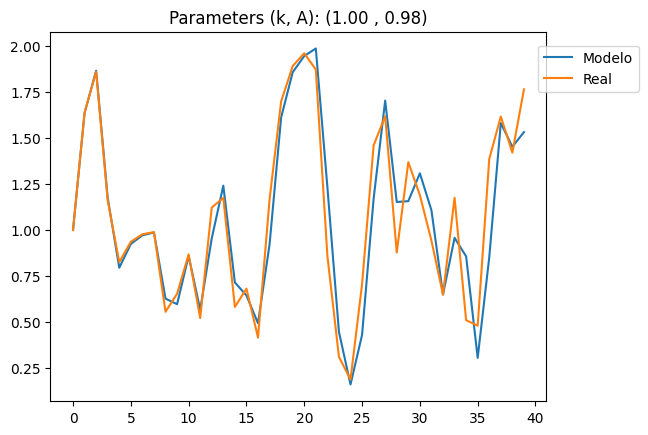

In [17]:
# training result
k,A = res.x
tspan = (0, len(t)-1)
t_sol = scipy.integrate.solve_ivp(dhdt_est, tspan, h0, t_eval=t, args=(k,A))
plt.title(f'Parameters (k, A): ({k:.2f} , {A:.2f})')

plt.plot(t_sol.t[:], t_sol.y.T[:], label='Modelo')
plt.plot(train.y[:], label ='Real')
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.9))
plt.show()

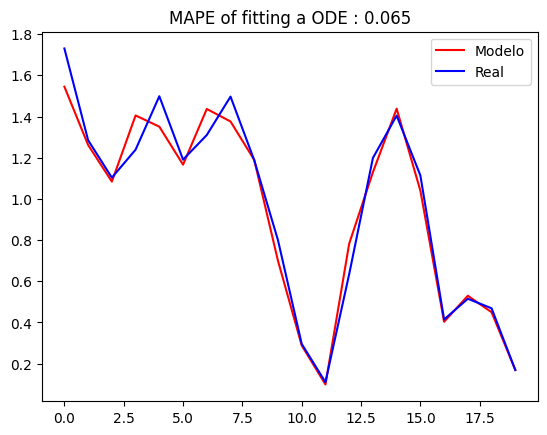

In [18]:
# Evaluating test data
y_predicted = []

for t in test.index:
    h0_test = test.loc[t,'ht_1'] #initial data
    ini = t
    tspan = (ini,ini+2)
    sol = scipy.integrate.solve_ivp(dhdt_est, tspan, [h0_test], t_eval=range(*tspan), args=(k,A))
    val = sol.y.reshape(-1)[1] #getting simulation
    y_predicted.append(val)

plt.title(f'MAPE of fitting a ODE : {mean_absolute_percentage_error(test.y.values, y_predicted):.3f}')
plt.plot(y_predicted, color='r', label='Modelo')
plt.plot(test.y.values, color='b', label = 'Real')
plt.legend()
plt.show()

## Using Kalman Filter to model the system dynamics

In a classical usage of Kalman Filter there is no exogenous (or inputs $u(t)$) to control the system. For this application we will need that in order to model the tank level when there are variations of the inlet flow $F_{in}(t)$.

http://bilgin.esme.org/BitsAndBytes/KalmanFilterforDummies


http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/


https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/08-Designing-Kalman-Filters.ipynb

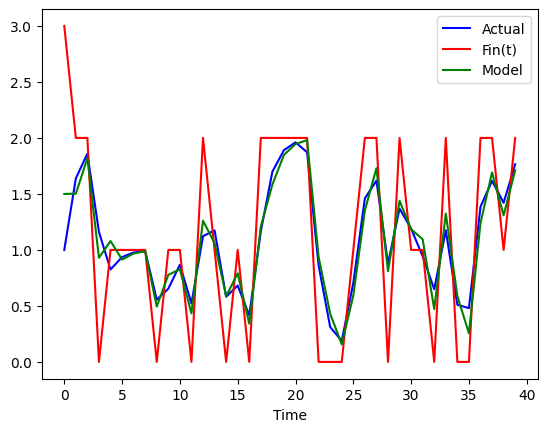

In [19]:
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org filterpy
from filterpy.kalman import KalmanFilter

f = KalmanFilter(dim_x=1, dim_z=1, dim_u=1)
measurements = train.y.values.copy()
numsteps = len(measurements)

init_state = measurements[0]
f.x = np.array([[init_state]])
f.F = np.array([[0.5]]) # dynamic design
f.B = np.array([[0.5]]) # control signal
f.H = np.array([[1]])
# covariance matrix
state_noise = 1
f.P = state_noise
# measurement noise
measure_noise = 0.01
f.R = np.array([[measure_noise]])  
# state uncertainty
f.Q = np.array([[state_noise]])
# control inputs
controls = train.Fin.values
# get true states
true_states = np.zeros(numsteps)
true_states[0] = init_state 
true_states += controls


estimates = []
covs = []
for n in range(numsteps):
    f.predict(u=controls[n])
    x = f.x
    estimates.append(x[0])
    covs.append(f.P[0])
    f.update(measurements[n])

plt.figure()
plt.plot(measurements, 'b')
plt.plot(true_states, 'r')
plt.plot(estimates, 'g')
plt.legend(('Actual', 'Fin(t)', 'Model'))
plt.xlabel('Time')
plt.show()

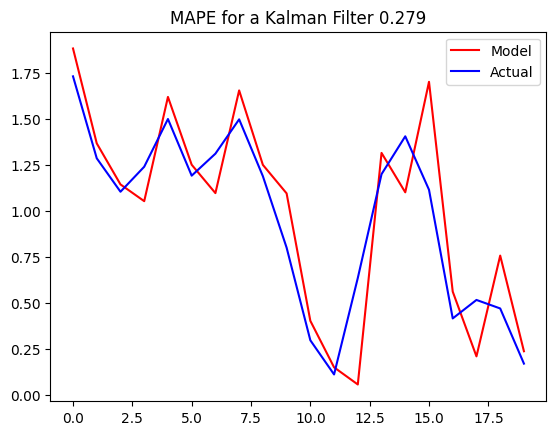

In [20]:
# evaluating test data
y_predicted = []

f.update(test.head(1)['ht_1'].values[0])
for t in test.index:  
    f.predict(u=test.loc[t,'Fin'])
    x = f.x
    y_predicted.append(x[0][0])
    #update after predict
    f.update(test.loc[t,'y'])
    
plt.title(f'MAPE for a Kalman Filter {mean_absolute_percentage_error(test.y.values, y_predicted):.3f}')
plt.plot(y_predicted, color='r', label='Model')
plt.plot(test.y.values, color='b', label = 'Actual')
plt.legend()
plt.show()

Simular performance when comparing with ARX model.

## Laplace transformation

The Laplace transformation can help us to understand a dynamic system in a frenquency domain. It is easier to analyse who a first order system will behavior in termos of gain and transition time

From equation (3):

(3) $ \frac{dh(t)}{dt} = F_{in}(t) - h(t)$

Applying Laplace transformation

(4) $  L\left\{ \frac{dh(t)}{dt}  \right\} = L\left\{F_{in}(t) - h(t)\right\}$

(5) $  s h(s) = F_{in}(s) - h(s)$

(6) $  h(s)(s + 1) = F_{in}(s) $

(7) $  h(s) = \frac{1}{(s + 1)}F_{in}(s) $

Often the input signal in this case $F_{in}$ cab be rename to $u$

(8) $  h(s) = \frac{1}{(s + 1)}u(s) $

In [21]:
t, K, tau = sympy.symbols('t, K, tau',real=True, positive=True)
s = sympy.Symbol('s')
u = sympy.Heaviside(t) #step

def L(f):
    return sympy.laplace_transform(f, t, s, noconds=True)
def invL(F):
    return sympy.inverse_laplace_transform(F, s, t)


In [22]:
U = L(u)
U

In [23]:
G = K/(tau*s + 1)
G

In [24]:
stepresponse = invL(G*U)
stepresponse

In [25]:
from ipywidgets import interact
evalfstep = sympy.lambdify((K, tau, t), stepresponse, 'numpy')

ts = np.linspace(0, 10)
def firstorder(tau_in, K_in):
    plt.figure(figsize=(12, 6))    
    ax_step = plt.subplot2grid((2, 2), (1, 0))
    
    tau_height = 1 - np.exp(-1)
    ax_step.set_title('Step response')
    ax_step.plot(ts, evalfstep(K_in, tau_in, ts))
    ax_step.axhline(K_in)
    ax_step.plot([0, tau_in, tau_in], [K_in*tau_height]*2 + [0], alpha=0.4)
    ax_step.text(0, K_in, '$K=${}'.format(K_in))
    ax_step.text(0, K_in*tau_height, '{:.3}$K$'.format(tau_height))
    ax_step.text(tau_in, 0, r'$\tau={:.3}$'.format(tau_in))
    ax_step.set_ylim(0, K_in+0.5)

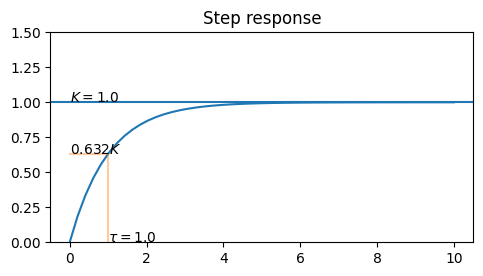

In [26]:
firstorder(1., 1.) #igual ao nosso gráfico exceto pelo ponto de partida diferente

In [27]:
interact(firstorder, tau_in=(0.1, 10.), K_in=(0.1, 10.))
# you can vary the gain (k_in) and the time constant of the sytem (tau_in)

interactive(children=(FloatSlider(value=5.05, description='tau_in', max=10.0, min=0.1), FloatSlider(value=5.05…

<function __main__.firstorder(tau_in, K_in)>

## Close loop and feedback

A close loop change the system behavior.

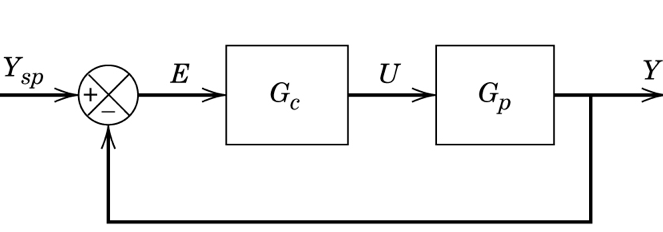

for our new example $ G_p $ é a first order system and $ G_c $ the controller. 

$ Y_{sp} $ is the set point, so, the desire value for $Y$. 

Observe the error $E$ which is the subtraction of the set point and the actual value is the input of the controller $ G_c $. 

The control signal $ U $ is send to the process.

In [28]:
# for this example we will use only the proporcional control
G_c = K_C = sympy.Symbol('K_C', positive=True)

In [29]:
s = sympy.Symbol('s')
tau = sympy.Symbol('tau', positive=True)

In [30]:
G_p = 1/(tau*s + 1)
G_p

In [31]:
#System anda controller together
G_OL = G_p*G_c

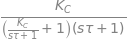

In [32]:
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org tbcontrol
from tbcontrol.loops import feedback
G_CL = feedback(G_OL, 1)
G_CL

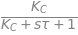

In [33]:
G_CL = G_CL.cancel() #canceling common factors
G_CL

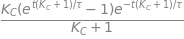

In [34]:
# bringing to time domain
t = sympy.Symbol('t', positive=True)
general_timeresponse = sympy.inverse_laplace_transform(sympy.simplify(G_CL/s), s, t)
general_timeresponse

In [35]:
from ipywidgets import interact
y_func = sympy.lambdify((K_C, tau, t), general_timeresponse, 'numpy')
smootht = np.linspace(0, 5)

def response(K_C=10, tau=10):
    y = y_func(K_C, tau, smootht)
    e = 1 - y
    fig, [ax_y, ax_e] = plt.subplots(2, 1)
    ax_y.plot(smootht, y)
    ax_y.axhline(1)
    ax_y.set_ylabel('Setpoint and y')

    ax_e.plot(smootht, e)
    ax_e.set_ylabel('Error')

In [36]:
interact(response, K_C=(0, 100), tau=(0, 20))

interactive(children=(IntSlider(value=10, description='K_C'), IntSlider(value=10, description='tau', max=20), …

<function __main__.response(K_C=10, tau=10)>

It is possible to realize that the controller never achieve the set point.

Lets combine what we see until now implemente a proporcional control for our model and also a PI (Proportional and Integral) controller.

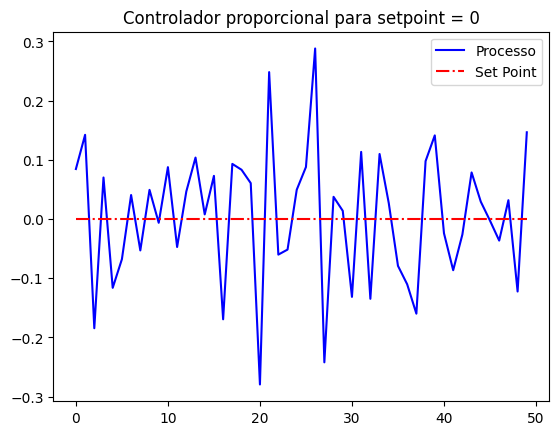

In [37]:
T = np.linspace(0, 30)

h_sp = np.random.randint(-3,3) #metros

#Controlador
K_C = 2

Y = []
control = 0
for t in T:
    f.predict(u=control) #filtro
    Y.append(f.x[0])
    error = h_sp - f.x[0] + np.random.randn()*0.1 # sinal com ruido
    control = error*K_C

plt.title(f'Controlador proporcional para setpoint = {h_sp}')
plt.plot(Y, 'b', label='Processo')
plt.plot(h_sp*np.ones(len(Y)),'-.r', label='Set Point')
plt.legend()
plt.show()

This is a proportional controll but the most common industrial controller is a PI controller( I stands for integral).
The PID (D stands for derivative) is avoided due to noise can affect the controller a lot.

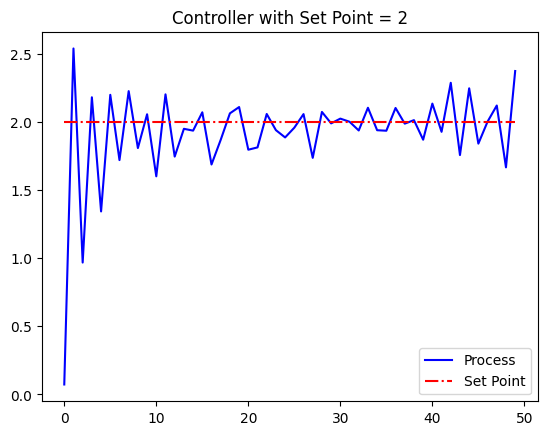

In [38]:
T = np.linspace(0, 30)

h_sp = np.random.randint(-3,3) #meters

#Controller
K_C = 2
K_I = 0.55

Y = []
ERRO = []
control = 0
for t in T:
    f.predict(u=control) #filter
    Y.append(f.x[0])
    error = h_sp - f.x[0] + np.random.randn()*0.1 # noise
    ERRO.append(error)
    control = error*K_C + sum(ERRO)*K_I

plt.title(f'Controller with Set Point = {h_sp}')
plt.plot(Y, 'b', label='Process')
plt.plot(h_sp*np.ones(len(Y)),'-.r', label='Set Point')
plt.legend()
plt.show()

# MPC - Model Predictive Control

The idea behind the MPC is to implement a optimization algorithm together with a predictive model. It is also possible to not only look for the process itself but to understand the surrounding processes.

To exemplify let use a second order system (equation 9):


(9)    $ G = \frac{1}{15s^2 + 8s + 1} $


To implement a MPC it is also possible to use a non parametric approach like ML models

In [39]:
import scipy.signal as ssig
G = ssig.lti([1], [15, 8, 1])

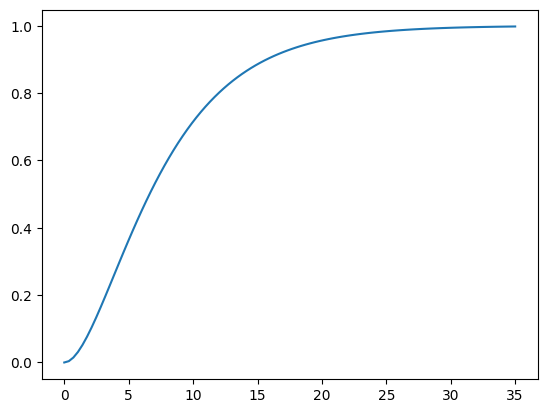

In [40]:
plt.plot(*G.step()) #step response

In [41]:
M = 10  # Control horizon
P = 20  # Prediction horizon
DeltaT = 1  # Sampling rate

tcontinuous = np.linspace(0, P*DeltaT, 1000)  # some closely spaced time points
tpredict = np.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon

u = np.ones(M)

In [42]:
x0 = np.zeros(G.to_ss().A.shape[0])

def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return np.concatenate([u, np.repeat(u[-1], P-M)])

def prediction(u, t=tpredict, x0=x0):
    """Predict the effect of an input signal"""
    t, y, x = ssig.lsim(G, u, t, X0=x0, interp=False)
    return y

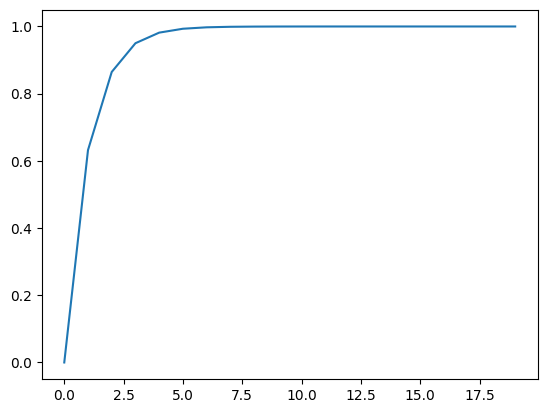

In [43]:
#r is the set-point
tau_c = 1
r = 1 - np.exp(-tpredict/tau_c)
plt.plot(r)

In [44]:
def objective(u, x0=x0):
    """Calculate the sum of the square error for the control problem"""
    y = prediction(extend(u))
    return sum((r - y)**2)

#Alternative
def objective_alt(u, x0=x0):
    y = prediction(extend(u))
    umag = np.abs(u)
    constraintpenalty = sum(umag[umag > 2]) #controller values >2 will be penalized
    movepenalty = sum(np.abs(np.diff(u))) #differences in controler values will be penalized
    strongfinish = np.abs(y[-1] - r[-1]) #convergence at the end of simulation
    
    return sum((r - y)**2) + 0.08*constraintpenalty + 0.05*movepenalty + 0.2*strongfinish

In [45]:
result = scopt.minimize(objective_alt, u)
uopt = result.x
result.fun

In [46]:
ucont = extend(uopt)[((tcontinuous-0.01)//DeltaT).astype(int)]

In [47]:
def plotoutput(ucont, uopt):
    plt.figure()
    plt.title('Control Signal')
    plt.plot(tcontinuous, ucont)
    plt.xlim([0, DeltaT*(P+1)])
    plt.figure()
    plt.title('Process')
    plt.plot(tcontinuous, prediction(ucont, tcontinuous), label='Continuous response')
    plt.plot(tpredict, prediction(extend(uopt)), '-o', label='Optimized response')
    plt.plot(tpredict, r, label='Set point')
    plt.legend()

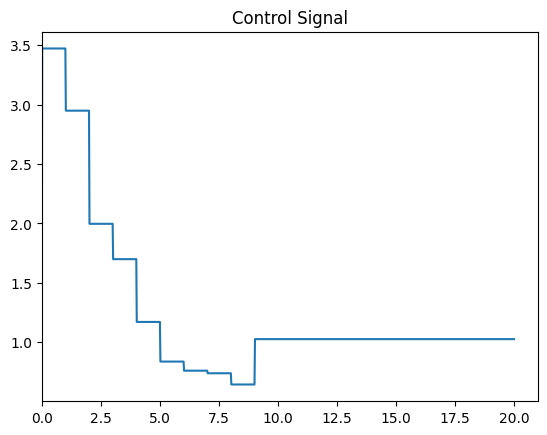

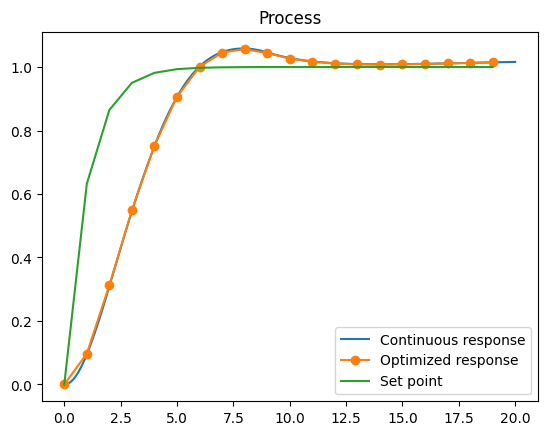

In [48]:
plotoutput(ucont, uopt)

## MPC - With Kalman Filter

Joining every together

In [49]:
setpoint = r
h0 = 0

#Model
def predict_y(U):
    Y = []
    f.x = [[h0]]
    for u in U:
        f.predict(u=u)
        Y.append(f.x[0][0])
    return Y

#objetive function
def obj(U):
    Y = predict_y(U)
    constraintpenalty = sum(U[U > 1.0])
    strongfinish = np.abs(Y[-1] - r[-1]) #convergencia no final da simulação
    return sum((setpoint- Y)**2) + 0.1*constraintpenalty + 0.1*strongfinish

M = len(r) #lenght of simulation
u = np.zeros(M)

result = scopt.minimize(obj, u)
uopt = result.x
result.fun

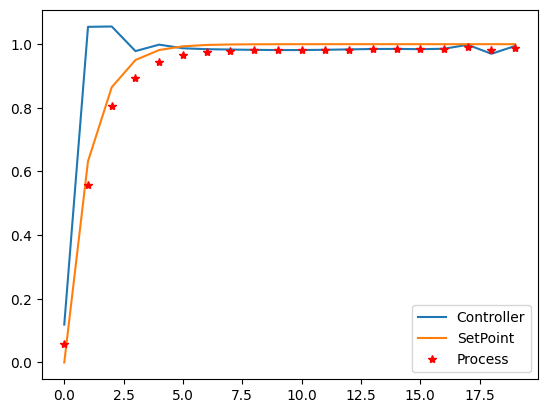

In [50]:
plt.plot(uopt, label = 'Controller')
plt.plot(setpoint, label = 'SetPoint')
plt.plot(predict_y(uopt), 'r*', label='Process')
plt.legend()
plt.show()

But in a real processo the model is no 100% accurate. So, we will split the model and the actual process in different parts of the simulation.

In [51]:
y_real = [0]
u_control = [0]
k,A = (1,1) #Actual plant dynamics

uopt=[0]
def get_control(t):
    return u_control[-1] #last control signal

#Modelo
def predict_y_k(U, x0):
    Y = []
    f.x = [[x0]]
    for u in U:
        f.predict(u=u)
        Y.append(f.x[0][0])
    return Y

#função objetivo
def obj_k(U, x0, t):
    Y = predict_y_k(U[t:],x0)
    return sum((setpoint[t:]- Y)**2) 


for t in range(M):    
    ######### Actual Plant  #############
    y0 = y_real[-1] 
    tspan = (0,2)
    sol = scipy.integrate.solve_ivp(dhdt_est, tspan, [y0], t_eval=range(*tspan), args=(k,A,get_control))
    y = sol.y.reshape(-1)[1] + np.random.randn()*0.1 - 0.05 #noise and offset
    ####################################
    ########### MPC + Kalman ###########
    u = np.zeros(M)
    result = scopt.minimize(obj_k, u, args=(y,t)) 
    uopt = result.x
    #############################
    y_real.append(y)
    u_control.append(uopt[t])

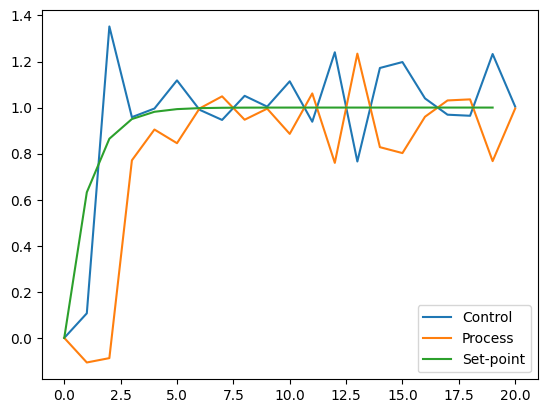

In [52]:
plt.plot(u_control, label='Control')
plt.plot(y_real, label= 'Process')
plt.plot(setpoint, label = 'Set-point')
plt.legend()
plt.show()

## Reinforcement Learning using Kalman Filter

We can write the reinforcement learning strategy as a replacement for the optimization algorithm. But this stratety is under using all the RL capabilities.

In [53]:
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org gym==0.19.0
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org tensorflow==1.13.2
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org stable_baselines
import gym
from stable_baselines.common.policies import MlpPolicy,MlpLstmPolicy,CnnPolicy
from stable_baselines import PPO2

class BasicEnv(gym.Env):
    def __init__(self):
        self.discretization = 20
        self.action_space = gym.spaces.Discrete(self.discretization)
        self.observation_space = gym.spaces.Discrete(self.discretization)
        self.setpoint = 1
        self.initial_state = 0
    def step(self, action):    
        U = self.decode_action(action)
        x0 = self.decode_state(self.state)
        
        y_pred = predict_y_k([U], x0)[0] #using Kalman as the model
        
        self.state = self.encode(y_pred)
        reward = 1-np.abs(self.setpoint-y_pred)
        done = True
        info = {}
        return self.state, reward, done, info
    def reset(self):
        self.state = self.initial_state
        return self.state
    def decode_action(self,action):
        return action/(self.discretization-4)#limit to 19/(19-4)
    def decode_state(self,state):
        return state/(self.discretization)
    def encode(self, x):
        return x*self.discretization


env = BasicEnv()

model = PPO2(MlpPolicy, env, verbose=0)
obs = env.reset()

action_vector = []
state_vector = []
env.state = 0
env.initial_state = 0
for s in setpoint:
    env.setpoint = s
    model.learn(total_timesteps=5000)
    action, _states = model.predict(obs)
    
    obs, rewards, dones, info = env.step(action)    
    env.initial_state = env.encode(
        predict_y_k([
            env.decode_action(action)],
            env.decode_state(
                env.initial_state
            )
        )[0]
    )        
    env.state = env.initial_state
    action_vector.append(env.decode_action(action))
    state_vector.append(env.decode_state(env.state))

c:\users\rmansur\onedrive - suzano s a\documentos\my-venv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\rmansur\onedrive - suzano s a\documentos\my-venv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\rmansur\onedrive - suzano s a\documentos\my-venv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\user

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.


c:\users\rmansur\onedrive - suzano s a\documentos\my-venv\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


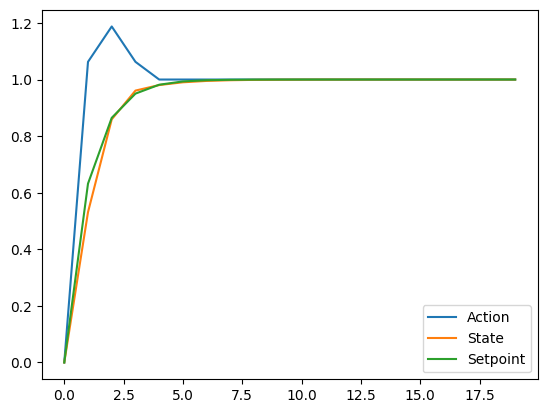

In [54]:
plt.plot(action_vector, label='Action')
plt.plot(state_vector, label='State')
plt.plot(setpoint, label='Setpoint')
plt.legend()
plt.show()

A complete strategy is to use the RL as real controller. So, once it was trained on the gym (kalman filter), we can use it in production and it can keep learning there.

In [55]:
class BasicEnv2(gym.Env):
    def __init__(self):
        self.discretization = 20
        self.action_space = gym.spaces.MultiDiscrete([self.discretization]*len(setpoint))        
        self.observation_space = gym.spaces.MultiDiscrete([self.discretization]*len(setpoint))
        self.update_setpoint()
        self.initial_state = [0]*len(setpoint)
    def update_setpoint(self):
        self.setpoint = setpoint
    def step(self, action):
        self.update_setpoint()
        signal_setpoint = sum(self.setpoint)/np.abs(sum(self.setpoint))
        U = np.array(self.decode_action(action))*signal_setpoint + self.setpoint
        #it should work in any given setpoint not on a specific one
        x0 = self.decode_state(self.state)[0]
        
        y_pred = np.array(predict_y_k(U, x0)) + np.random.randn(len(setpoint))*0.1 - 0.05 
        #using Kalman as the model with noise
        
        self.state = y_pred
        reward = 1-sum((self.setpoint-y_pred)**2)
        done = True
        info = {}
        return self.state, reward, done, info
    def reset(self):
        self.state = self.initial_state
        return self.state
    def decode_action(self,action):
        return [a/(self.discretization-4) for a in action]
    def decode_state(self,state):
        return [s/(self.discretization) for s in state]
    def encode(self, value):
        return [v*self.discretization for v in value]


env = BasicEnv2()

model = PPO2(MlpPolicy, env, verbose=0)
model.learn(total_timesteps=20000)

obs = env.reset()
action_vector = [0]*len(setpoint)
state_vector = []
env.state = [0]*len(setpoint)
env.initial_state = [0]*len(setpoint)

########Start testing model########
[ 2  1  4  3  2  0  2  0  0  1  2  0  0  1  0  1  0  0  0 18]
Rewards 0.6416036968783384


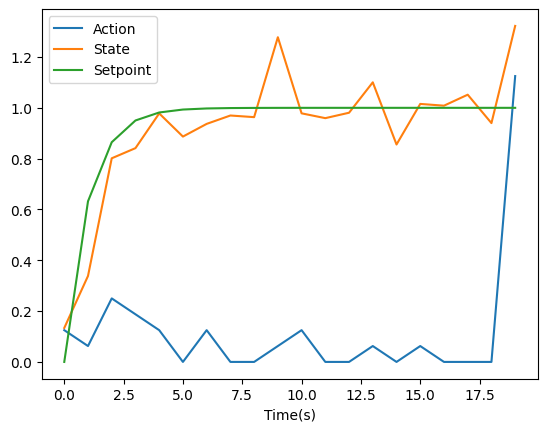

In [56]:
print('########Start testing model########')
action, _states = model.predict(obs)
print(action)
obs, rewards, dones, info = env.step(action)
print('Rewards',rewards)
action_vector = env.decode_action(action)
state_vector = env.state
plt.plot(action_vector, label='Action')
plt.plot(state_vector, label='State')
plt.plot(setpoint, label='Setpoint')
plt.xlabel('Time(s)')
plt.legend()
plt.show()

######## Start testing model with another setpoint ########
[3 8 5 3 1 0 1 6 1 1 2 0 0 1 0 1 0 1 0 0]
Rewards 0.48613757835406446


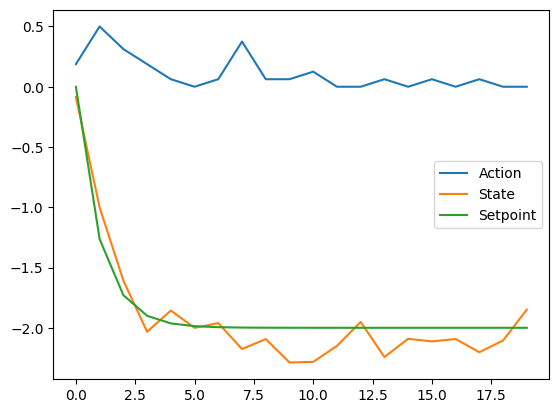

In [57]:
setpoint = -2*setpoint
print('######## Start testing model with another setpoint ########')
action, _states = model.predict(obs)
print(action)
obs, rewards, dones, info = env.step(action)
print('Rewards',rewards)
action_vector = env.decode_action(action)
state_vector = env.state
plt.plot(action_vector, label='Action')
plt.plot(state_vector, label='State')
plt.plot(setpoint, label='Setpoint')
plt.legend()
plt.show()

# MPC - Industry Example

The digestor is the main industrial process to produce pulp from wood. It is utmost importance to have a good cooking process to guarantee efficiency and quality of the final product.


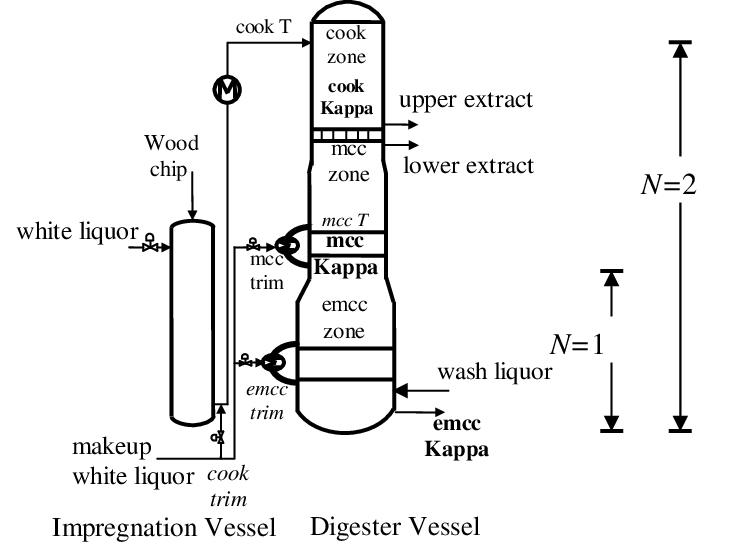


For such an importance in the industry there are modelling strategies dating 40 year ago. One of the well accepted models are provided by the folllowing differential equations [Gustafson83]. They describe the residual lignin over time. Lignin is the substance that the cooking process are separating from the wood fibers and it is usually burned after the cooking process.




(10)  $ \frac{dL}{dt} = k_{il}e^{(17.5-8750/T)}L $  para L >= 0.22

(11)  $ \frac{dL}{dt} = k_{0bl}e^{(A_1-B_1/T)}[OH^-]L + k_{1bl}e^{(A_2-B_2/T)}[OH^-]^{0.5}[HS^-]^{0.4}L $ para 0.03 < L < 0.22 

(12)  $ \frac{dL}{dt} = k_{r1}e^{(19.64-10804/T)}[OH^-]^{0.7}L $ para L < 0.03



In [58]:
#Generating data

T_celsios = 190
T = T_celsios + 273.15 # temperature em Kelvins
k_temp = np.exp(17.5-8750/T)
l0 = .5
Kil = 0.2 
kb_0 = 0.1
kb_1 = 0.5
kr_0 = 1
OH = 18/100
HS = 0.30
A1 = 29
B1 = 19500
A2 = 15.9
B2 = 9500
PROD = 3000 #Production tsa

#simulation frame
n = 4*60
tspan = (0, n)
t = np.linspace(*tspan, n) 

In [59]:
#GUSTAFSON’S KAPPA NUMBER MODEL

def dldt(t, l): 
    '''Gustafson'''
    if l >= 0.22: #primeira zona
        return -1*(Kil*np.exp(17.5-9390/T)*l)
    elif l < 0.22 and l > 0.03:
        return -1*(kb_0*np.exp(A1-B1/T)*OH + kb_1*np.exp(A2-B2/T)*(OH**0.5)*(HS**0.4))
    else: # l <= 0.03
        return -1*kr_0*np.exp(19.64-10804/T)*OH**0.7*l

In [60]:
sol = scipy.integrate.solve_ivp(dldt, tspan, [l0], t_eval=t)

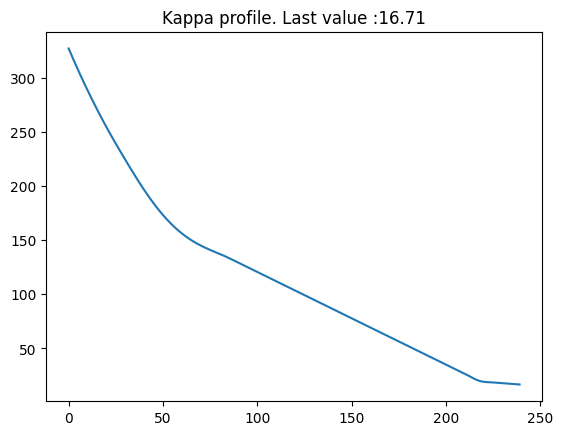

In [61]:
plt.title(f'Kappa profile. Last value :{(sol.y.T/0.00153)[-1][0]:.2f}')
plt.plot(sol.y.T/0.00153)
plt.show()

In [62]:
import os

simulation_file = 'simulacao_digestor.csv'
simulation_file_exists = os.path.exists(simulation_file)

if not simulation_file_exists:
    np.random.seed(1245)
    num_horas = 48
    simul_data = []
    for i in range(0,num_horas):
        fator_estabilidade = (num_horas-i)/num_horas
        row = [(i)*60,
               OH + np.random.randn()/200*fator_estabilidade, 
               HS + np.random.randn()/200*fator_estabilidade, 
               T + np.random.randn()*fator_estabilidade,
              PROD - abs(np.random.randn())*300]
        simul_data.append(row)

    df_simula = pd.DataFrame(data=simul_data, columns=['time','OH','HS','T','PROD'])
    #dados com níveis horários para usar no modelo

    def get_var(t, var):
        return np.interp(t, df_simula.time, df_simula[var])

    simulacao = num_horas*60 #tempo total de simulação
    ttspan = (0, simulacao)
    tt = np.linspace(*ttspan, simulacao) 
    dados = []

    for s in tt:
        dado = []
        sol = scipy.integrate.solve_ivp(dldt, tspan, [l0], t_eval=t)

        prod = get_var(s,'PROD')
        t_residencia = int(n*prod/PROD) #calculando tmepo de residencia para a producao
        dado.append((sol.y.T/0.00153)[t_residencia][0]) #kappa
        dado.append(prod)   

        #O ruido nesta etapa está oculto dos dados representando outros fatores não mensurados
        OH = get_var(s,'OH') + np.random.randn()/1000 
        dado.append(get_var(s,'OH'))
        HS = get_var(s,'HS') + np.random.randn()/1000
        dado.append(get_var(s,'HS'))
        T = get_var(s,'T') + np.random.randn()/50
        dado.append(get_var(s,'T'))    
        dados.append(dado)

    df_simulacao = pd.DataFrame(data=dados, columns=['kappa','producao','alcali', 'HS', 'T'])
    df_simulacao.to_csv(simulation_file)
else:
    df_simulacao = pd.read_csv(simulation_file)

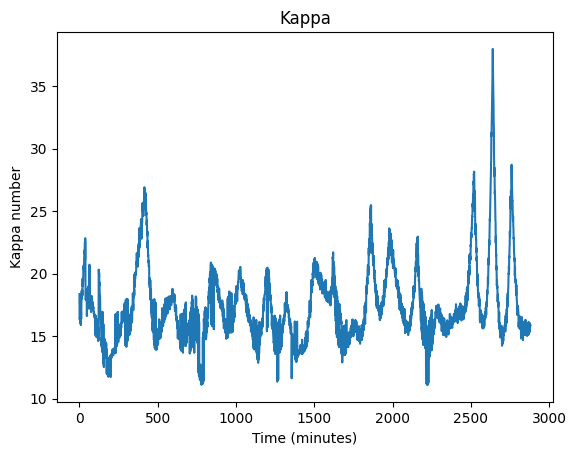

In [63]:
df_simulacao.kappa.plot(title='Kappa')
plt.xlabel('Time (minutes)')
plt.ylabel('Kappa number')
plt.show()

In [64]:
df_simulacao['kappa_t_1'] = df_simulacao.kappa.shift(1)
df_simulacao.fillna(df_simulacao.head(1)['kappa'].values[0], inplace=True)

train = df_simulacao[:2000]
test = df_simulacao[2000:]

In [65]:
train.head(3)

,Unnamed: 0,kappa,producao,alcali,HS,T,kappa_t_1
0,0,18.370153,2599.151658,0.187708,0.298747,465.128563,18.370153
1,1,16.349164,2600.791691,0.187696,0.298577,465.096022,18.370153
2,2,16.336770,2602.431723,0.187684,0.298407,465.063481,16.349164


                            OLS Regression Results                            
Dep. Variable:                  kappa   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     3161.
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:18:11   Log-Likelihood:                -2789.7
No. Observations:                2000   AIC:                             5589.
Df Residuals:                    1995   BIC:                             5617.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    332.8748     25.833     12.886      0.0

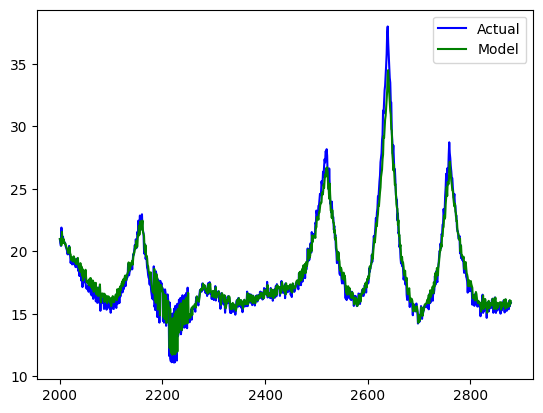

In [66]:
def train_model(p_train, eq):
    model = smf.ols(eq, data=p_train).fit()

    print(model.summary())

    plt.figure()
    plt.plot(test.kappa, 'b')
    plt.plot(model.predict(test[['kappa_t_1','alcali','producao', 'T']]), 'g')
    plt.legend(('Actual', 'Model'))
    plt.show()
    return model

train_model(train, "kappa ~ kappa_t_1 + alcali + producao + T")

In [67]:
#Seems that the model dit not understand the relation between resident time (production) and kappa the signal from the coeficient is inverted
#More production means bigger kappa keeping the other variables stable
print('Production third quartil kappa(>19) :', 
      train.loc[train.kappa>19]['producao'].mean()) #third quartil  kappa

print('Production first quartil kappa(<16) :', 
      train.loc[train.kappa<16]['producao'].mean()) #first quartil  kappa

Production third quartil kappa(>19) : 2647.5047569136855
Production first quartil kappa(<16) : 2839.8930898671997


                                 OLS Regression Results                                
Dep. Variable:                  kappa   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          2.801e+05
Date:                Thu, 10 Nov 2022   Prob (F-statistic):                        0.00
Time:                        10:18:11   Log-Likelihood:                         -2901.0
No. Observations:                2000   AIC:                                      5806.
Df Residuals:                    1998   BIC:                                      5817.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

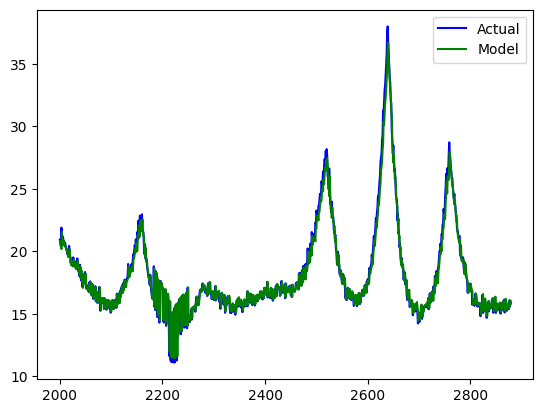

In [68]:
#We will make a model in steps and the first only considering production and a auto regressive term
model_prod_only = train_model(train,"kappa ~ kappa_t_1 + producao -1") #without intercept
#found a positive coeficient as expected

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     3850.
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:18:12   Log-Likelihood:                -2887.0
No. Observations:                2000   AIC:                             5782.
Df Residuals:                    1996   BIC:                             5804.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    106.6378     21.415      4.980      0.0

c:\users\rmansur\onedrive - suzano s a\documentos\my-venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\rmansur\onedrive - suzano s a\documentos\my-venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


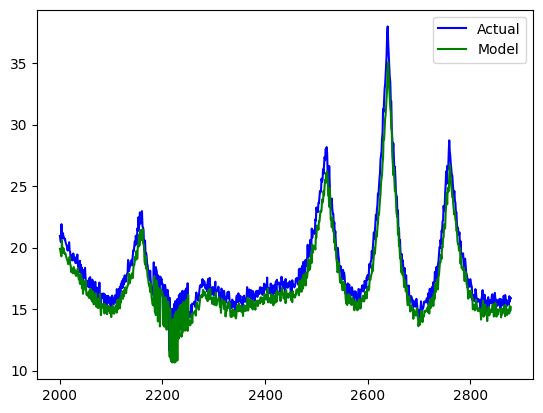

In [69]:
train['fator_producao'] = model_prod_only.params['producao']*train.producao
train['y'] = train.kappa-train.fator_producao 

model = train_model( train, 'y ~ kappa_t_1 + T + alcali')

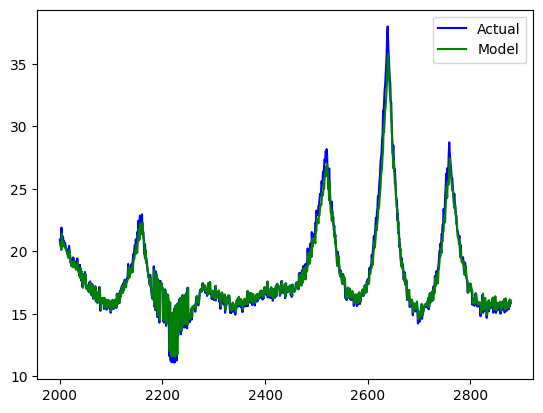

In [70]:
def predict_kappa(p_df):
    return p_df.producao * model_prod_only.params['producao'] + model.predict(p_df)
    
def predict_kappa_mpc(np_data, kappa_t_1):
    #used for mpc optimization without pandas to improve performance
    np_data = np.append(np_data, kappa_t_1)
    return np_data[1] * model_prod_only.params['producao'] + model.predict({'kappa_t_1':np_data[3],
                                                                            'alcali':np_data[2],
                                                                            'producao':np_data[1], 
                                                                            'T':np_data[0]})[0]


plt.figure()
plt.plot(test.kappa, 'b')
plt.plot(predict_kappa(test[['kappa_t_1','alcali','producao', 'T']]), 'g')
plt.legend(('Actual', 'Model'))
plt.show()

In [75]:
#Putting all together
#Lets use our ARX model to build the MPC

kappa0 = test.tail(1)['kappa'].values[0]
sp_kappa = r*2 + kappa0 #kappa_setpoint

#Model
def predict_y(U):
    MM = int(len(U)/3)
    U_c = U.reshape(3,MM)
    Y = []
    for i in range(0,MM):
        if len(Y)>0:
            x = predict_kappa_mpc(U_c[:,i], 
                                  Y[-1] + np.random.randn()*0.02) 
            #ruido no predict como proxy do mundo real
        else:
            x = predict_kappa_mpc(U_c[:,i], kappa0)
        Y.append(x)
    return Y

def obj(U):
    """Objective Function"""
    U_T = U[0:M]
    U_PROD = U[M:2*M]
    U_OH = U[2*M:3*M]
        
    constraint_T_min = U_T[U_T<(T-3)].size
    constraint_T_max = U_T[U_T>(T+2)].size
    constraint_OH_min = U_T[U_OH<=(OH-.01)].size*3
    constraint_OH_max = U_T[U_OH>=(OH+.01)].size*3
    
    max_producao = sum((PROD-U_PROD))
       
    Y = predict_y(U)
    return sum((sp_kappa- Y)**2) + (constraint_T_max + 
                                    constraint_T_min +
                                    constraint_OH_min +
                                    constraint_OH_max)*100 + max_producao*10

M = len(r) #lenght of simulation
u = np.concatenate((np.ones(M)*test[['T']].tail(1).values[0][0],
                    np.ones(M)*test[['producao']].tail(1).values[0][0], 
                    np.ones(M)*test[['alcali']].tail(1).values[0][0]))

result = scopt.minimize(obj, u, bounds=[(OH-0.02,3100)]*len(u), method='Powell') 
#hard bounds: the lowest value is OH limit and the max are the production limit
uopt = result.x
result.fun

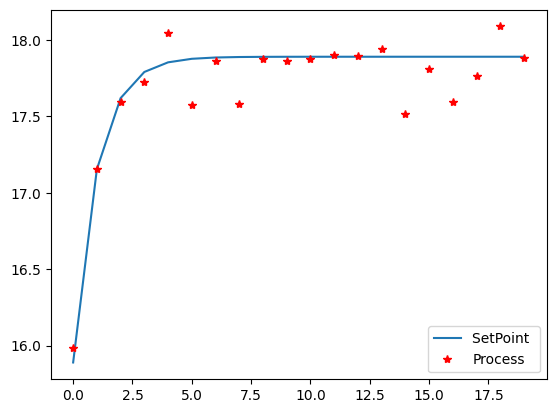

In [76]:
plt.plot(sp_kappa, label = 'SetPoint ')
plt.plot(predict_y(uopt), 'r*', label='Process')
plt.legend()
plt.show()

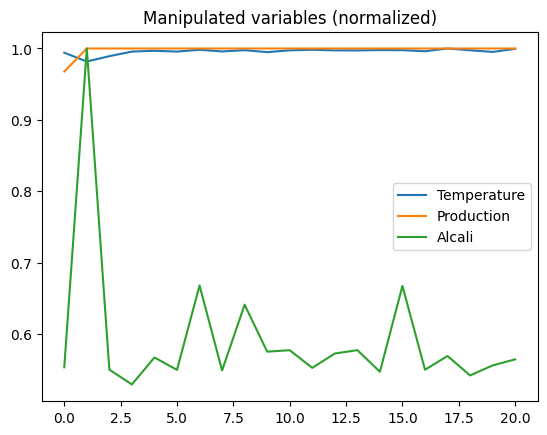

In [77]:
#Temperatue, Production e Alcali
temp_mv = np.insert(uopt[0:M], 0, T, axis=0)
prod_mv = np.insert(uopt[M:2*M], 0, PROD, axis=0)
OH_mv = np.insert(uopt[2*M:3*M], 0, OH, axis=0)

plt.plot(temp_mv/max(temp_mv), label='Temperature')
plt.plot(prod_mv/max(prod_mv), label='Production')
plt.plot(OH_mv/max(OH_mv), label='Alcali')
plt.title('Manipulated variables (normalized)')
plt.legend()

In [78]:
temp_mv, prod_mv, OH_mv

(array([463.15      , 457.39966871, 460.88866415, 463.87160639,
        464.39912302, 463.88729638, 465.05557808, 463.96632926,
        464.78591407, 463.51307119, 464.69024822, 465.05378265,
        464.66096063, 464.61339097, 464.87607433, 464.79002871,
        464.07869868, 465.90541326, 464.72800536, 463.64935673,
        465.65690031]),
 array([3000.        , 3099.97847417, 3099.99755343, 3099.98848415,
        3099.98821293, 3099.97973719, 3099.99260149, 3099.96443682,
        3099.98831892, 3099.97790946, 3099.98561124, 3099.97855254,
        3099.97143732, 3099.98988843, 3099.97134528, 3099.9956006 ,
        3099.99041618, 3099.92312014, 3099.98773411, 3099.99862537,
        3099.97952531]),
 array([0.18      , 0.325165  , 0.17891788, 0.17216412, 0.18446771,
        0.1788044 , 0.21722831, 0.1785603 , 0.20848479, 0.18711526,
        0.18776669, 0.17974002, 0.1862534 , 0.18780448, 0.17795382,
        0.21703813, 0.17888792, 0.1851237 , 0.17627287, 0.18084454,
        0.18360874]

The SCIPY optimization method is quite limited to work with a more complex simulation. In real life it would be considered use another optimization library such as pyomo.

(Link for MPC examples writing in pyomo https://github.com/jckantor/ND-Pyomo-Cookbook/tree/main/notebooks)


References:
    
    [Gustafson83] GUSTAFSON, R. G., SLEICHER, C. A., MCKEAN,W. T. FINLAYSON, B.A. Theoretical model of the kraft pulping process. Ind. and Eng. chem process Des.Dev. 22(1): 87-96 (1983).
    
    https://www.do-mpc.com/en/latest/
    
    https://dynamics-and-control.readthedocs.io/en/latest/